# BE Machine Learning

William SCHNEIDER, Minh Quan NGUYEN

# Environnement

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import math

import xgboost as xgb

# Introduction

Le dossier complet de l'UCI Student Performance contient deux jeux de données distincts : un pour les notes de cours de Mathématiques (student-mat.csv) et un autre pour les notes de Langue Portugaise (student-por.csv). On ne peut pas joindre les 2 datasets, il ne s'agit pas des mêmes élèves. 

Nous avons choisi de nous concentrer exclusivement sur le jeu de données des Mathématiques (mais vous pouvez changer dans la cellule suivant en décommentant, mais attention les interprétations ne seront pas les mêmes). L'étude que nous proposons aurait été la même avec l'autre jeu de donnée ce qui nous a motivé dans ce choix

L'objectif principal de ce projet est de construire un modèle de régression capable de prédire la note finale de l'élève, désignée par la variable cible $G3$ (note finale du troisième trimestre), en se basant sur les diverses caractéristiques socio-démographiques et scolaires (comme $G1$, $G2$, studytime, failures, etc.).

## Chargement des données

In [2]:
# Target : note en Mathématiques
df = pd.read_csv("student-mat.csv", sep = ";")

#Pour changer la target pour les notes en portugais
#df = pd.read_csv("student-por.csv", sep = ";")

In [3]:
print(df.head())
print(df.info())


  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (to

# 1) Exploration des données et définition du cadre de notre étude

## Définition et analyse de la target

Nous commençons par cibler la note finale, $G3$, car elle représente la performance académique la plus pertinente à prédire, à savoir prédire le succès ou l'échec finale de l'élève.

Toutefois, nous avons identifié que $G3$ est très fortement corrélée aux notes intermédiaires $G1$ et $G2$. Inclure ces variables rend le modèle presque trop facile et masque l'influence des facteurs non académiques (sociaux et démographiques). 
Pour obtenir une prédiction plus utile et évaluer l'impact des facteurs de fond, nous allons donc explorer deux scénarios alternatifs :
- Prédiction de $G2$ : Utiliser $G2$ comme variable cible en retirant $G3$ du jeu de données.
- Prédiction de $G1$ : Utiliser $G1$ comme variable cible en retirant $G2$ et $G3$ du jeu de données. 

Ce dernier scénario représente l'exercice le plus difficile, car il se base principalement sur les caractéristiques de fond de l'élève au début de l'année. Mais nous verrons ça plus tard, comme annocé, nous définissons G3 comme target principale.

In [4]:
y = df["G3"] 
print(y.info())

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: G3
Non-Null Count  Dtype
--------------  -----
395 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB
None


Il s'agit d'une variable qu'on considérera comme continue, nous serons bien dans un tâche de **régression** et non pas de classification.
Et comme nous le rappelons, nous avons une target, nous avons des données labellisés nous sommes donc sur un travail d'**apprentissage supervisé**.

On peut regarder plus précisément la distribution de la target.

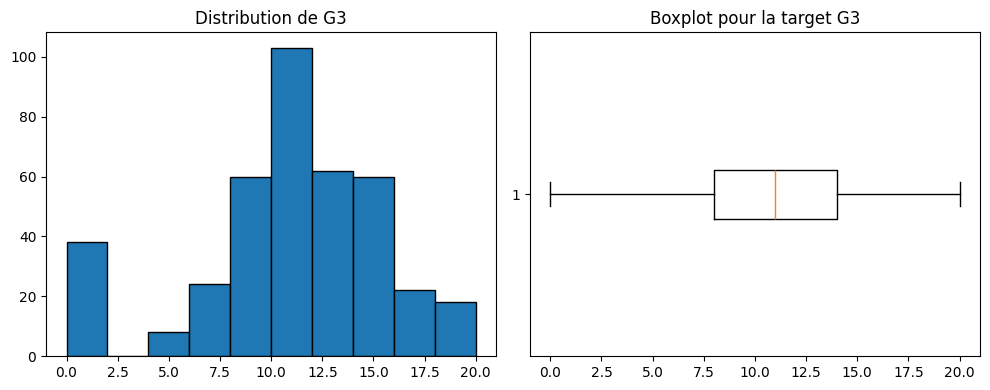

In [5]:
figure, axes = plt.subplots(nrows =1, ncols = 2, figsize = (10,4))

axes[0].hist(y.values, edgecolor = "black")
axes[0].set_title("Distribution de G3")

axes[1].boxplot(y.values, vert = False)
axes[1].set_title("Boxplot pour la target G3")

plt.tight_layout()
plt.show()



- Histogramme : La distribution des notes G3 est clairement asymétrique à gauche. La grande majorité des élèves obtient des notes dans la plage 10-15, avec un pic très marqué autour de 12,5. Il y a une concentration notable de notes élevées. Cependant, on remarque un groupe d'élèves qui ont obtenu une note de 0, ce qui forme une barre distincte à l'extrême gauche.

- Boxplot : Ce graphique confirme la tendance.

    - La médiane (la ligne au milieu de la boîte) se situe aux alentours de 12.

    - La boîte elle-même s'étend approximativement de 10 à 14 (l'intervalle interquartile), montrant que la moitié des élèves a une note dans cette fourchette assez serrée.

    - Les moustaches s'étendent, des notes très basses jusqu'à la note maximale de 20.

En résumé, la classe a plutôt bien réussi avec une majorité de bonnes notes, mais il y a une queue de distribution vers le bas, incluant un groupe d'élèves qui ont eu 0.

Maintenant, on cherche à savoir quelles variables (features) expliquent cette note finale G3.

## Exploration des features

In [6]:
X = df.drop("G3", axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

Il est important de noter que toutes nos variables d'entrée ne se comportent pas de la même façon. Nous avons les :

1) Variables Quantitatives : Ce sont des données numériques continues (comme l'âge, le nombre d'absences, ou les notes précédentes $G1$ et $G2$). 

2) Variables Catégorielles : Elles représentent des groupes, mais il y a deux possibilités :
    - Catégorielles Ordonnées : Elles sont déjà encodées avec des chiffres (par exemple, de 1 à 4) car elles représentent une échelle ou une hiérarchie (comme le niveau d'éducation des parents, la qualité des relations, etc.). Même si ce sont des données numériques, elles représentent des catégories.
    - Catégorielles sans ordre : Elles représentent des groupes qui n'ont à priori pas de lien de hiérarchie (comme le sexe, si l'élève est en internat ou non, etc.). Elles sont souvent sous forme de string et devront être transformées en nombres pour que notre modèle les comprenne.

Commencons par explorer les variables quantitatives

### Features quantitatives

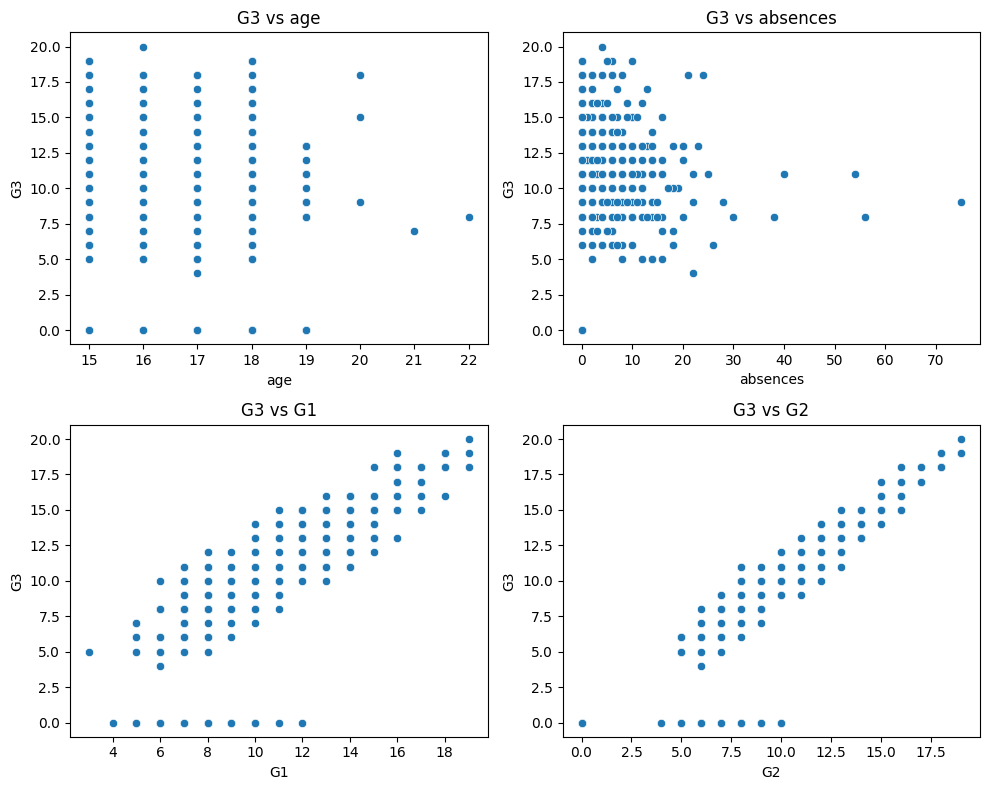

In [7]:
numeric_features = ["age", "absences", "G1", "G2"]

n = len(numeric_features)
ncols = math.ceil(math.sqrt(n))
nrows = math.ceil(n / ncols)

plt.figure(figsize=(5 * ncols, 4 * nrows)) 

for i in range(n):
    plt.subplot(nrows, ncols, i+1)  
    sns.scatterplot(x=df[numeric_features[i]], y=df["G3"])
    plt.title(f"G3 vs {numeric_features[i]}")

plt.tight_layout()
plt.show()


Les nuages de points montrent les relations suivantes avec la note finale $G3$ :
- $G1$ et $G2$ : Ces variables présentent une forte corrélation positive linéaire avec $G3$. On se doute que G3 va dépendre de ces features.
- Absences : La corrélation est faible et les données sont dispersées. On constate néanmoins que les élèves ayant les meilleures notes ($G3$) ont généralement un faible nombre d'absences.
- Âge : La distribution des notes est dispersée, avec les meilleures performances concentrées chez les élèves plus jeunes (15-18 ans). Notons que l'âge pourrait être traité comme une variable catégorielle/ordinale dans la phase de prétraitement.

Désormais nous nous intéresser aux variables catégorielles. 
Comme expliqué plus haut nous allons ici, juste pour la forme distinguer les variables catégorielles ordonnées, des variables catégorielles non ordonnées. 

### Ordinals Features

In [8]:
cols_int64 = df.select_dtypes(include=['int64']).columns.tolist()
ordinals_features = [col for col in cols_int64 if col not in (numeric_features+["G3"])]
print(ordinals_features)

['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']


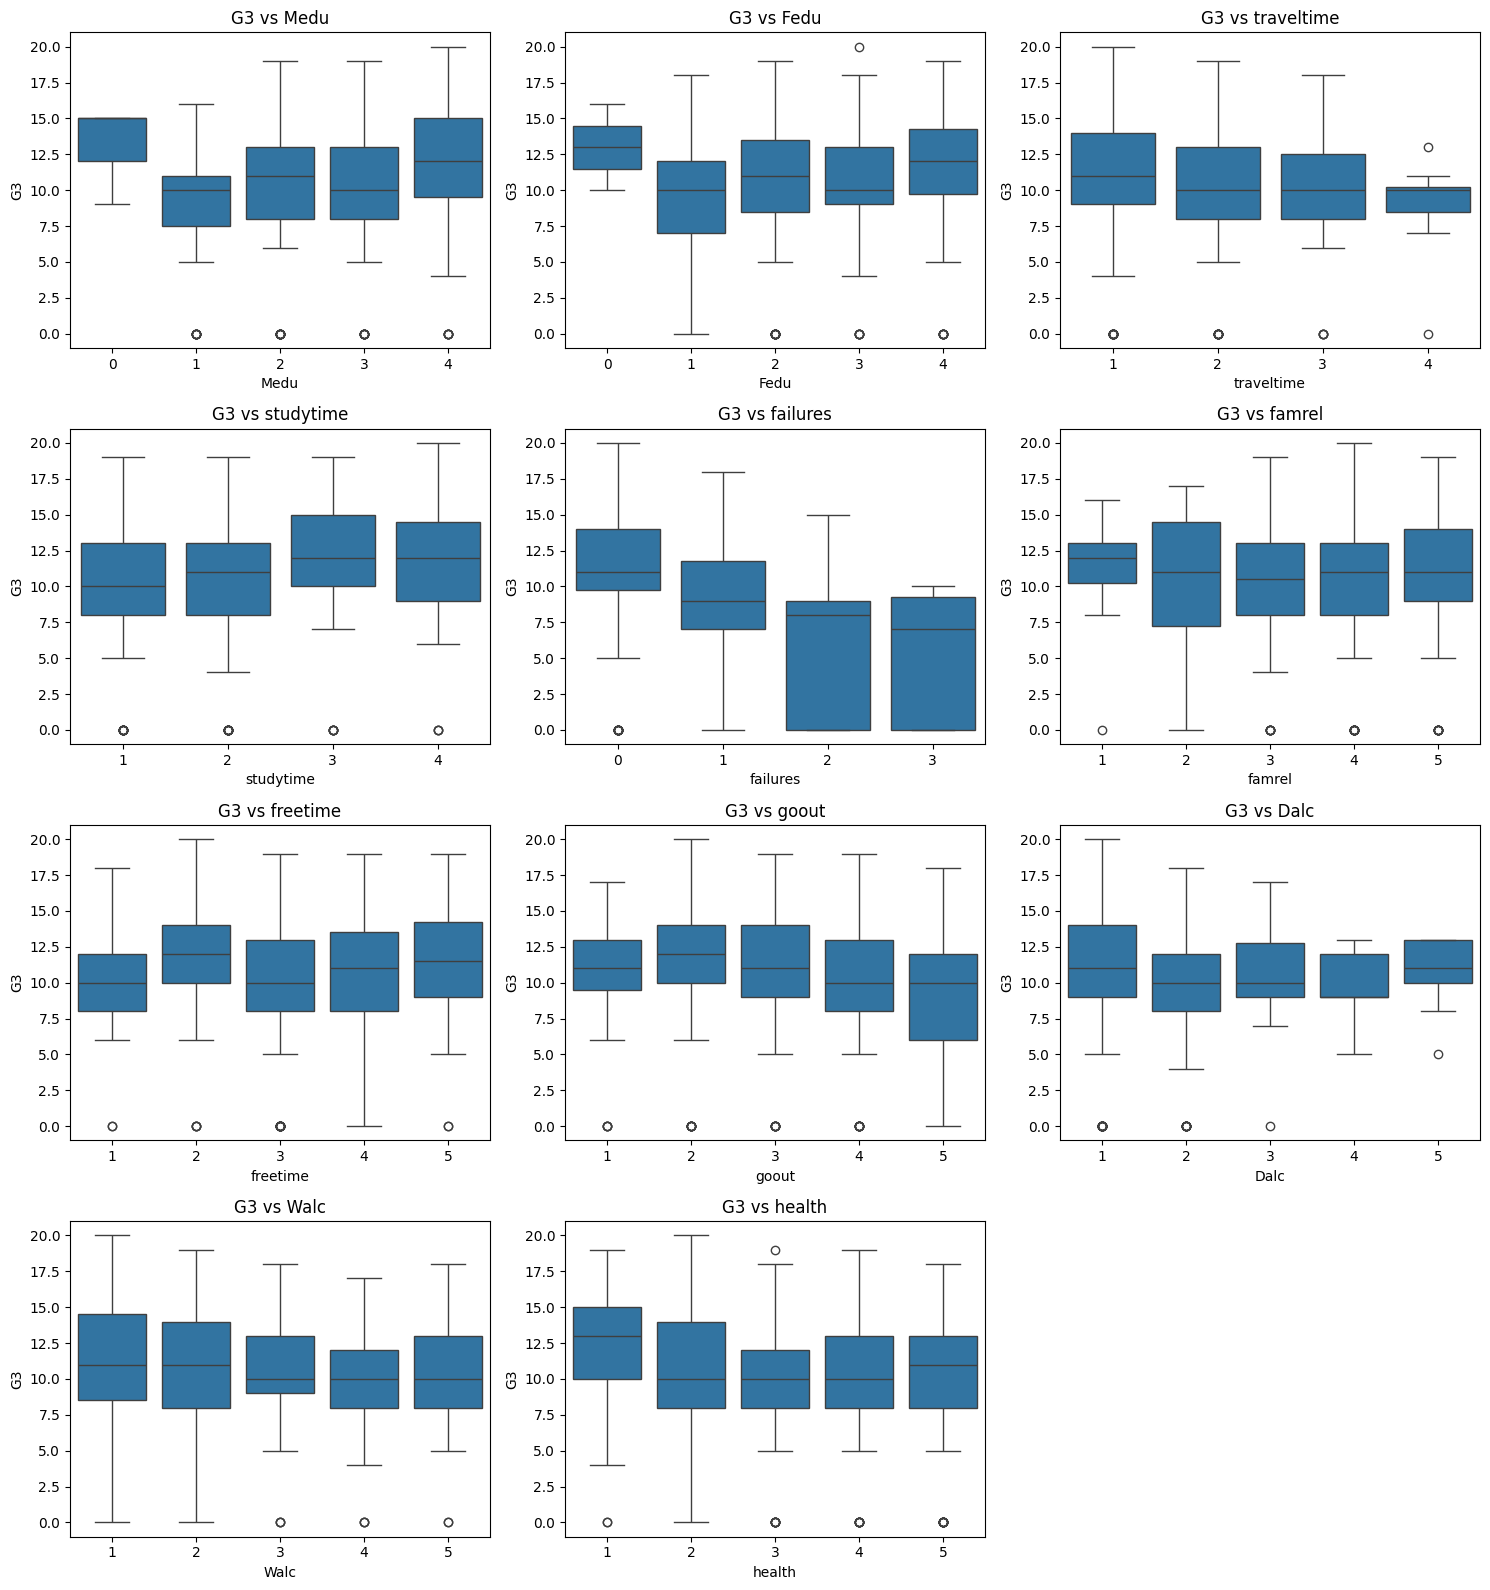

In [9]:
n = len(ordinals_features)

nrows = math.ceil(math.sqrt(n))
ncols = math.ceil(n / nrows)

plt.figure(figsize=(5 * ncols, 4 * nrows)) 

for i in range(n):
    plt.subplot(nrows, ncols, i+1)  
    sns.boxplot(x=df[ordinals_features[i]], y=df["G3"])
    plt.title(f"G3 vs {ordinals_features[i]}")

plt.tight_layout()
plt.show()


**Impact Positif Clair (Médiane en hausse)**
- Medu (Éducation de la mère) & Fedu (Éducation du père) : On observe une légère augmentation de la note médiane ($G3$) à mesure que le niveau d'éducation des parents augmente (de 0 à 4).
- Studytime (Temps d'étude hebdomadaire) : Les notes médianes sont légèrement meilleures pour les catégories de temps d'étude plus élevées (4 : $> 10$ heures).
- Famrel (Qualité des relations familiales) : La catégorie 3 (moyenne) semble avoir la médiane la plus basse, mais les relations familiales très bonnes (5) montrent de bonnes performances.

**Impact Négatif Clair (Médiane en baisse)**
- Failures (Nombre d'échecs passés) : C'est la tendance la plus nette. La note médiane ($G3$) chute significativement à mesure que le nombre d'échecs augmente (de 0 à 3).

**Impact Limité / Non Linéaire**
- Traveltime, Freetime, Goout, Dalc (Consommation d'alcool en semaine), Walc (Consommation d'alcool en week-end), et Health (État de santé) : L'impact sur la note médiane ($G3$) est faible ou non linéaire. Les variations observées entre les catégories ne sont pas assez importantes ou cohérentes pour en tirer des conclusions robustes.

### Nominal features

Il s'agit maintenant de s'intéresser aux variables catégorielles non numériques.
Attention concernant l'interprétation des graphiques
On ne parle plus de tendance parce que réorganiser les catégories n'aurait aucun impact sur le graphique. On parle uniquement de l'existence d'un écart entre les groupes.

In [10]:
non_ordinals_features = df.select_dtypes(include=['object']).columns.tolist()
print(non_ordinals_features)

['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


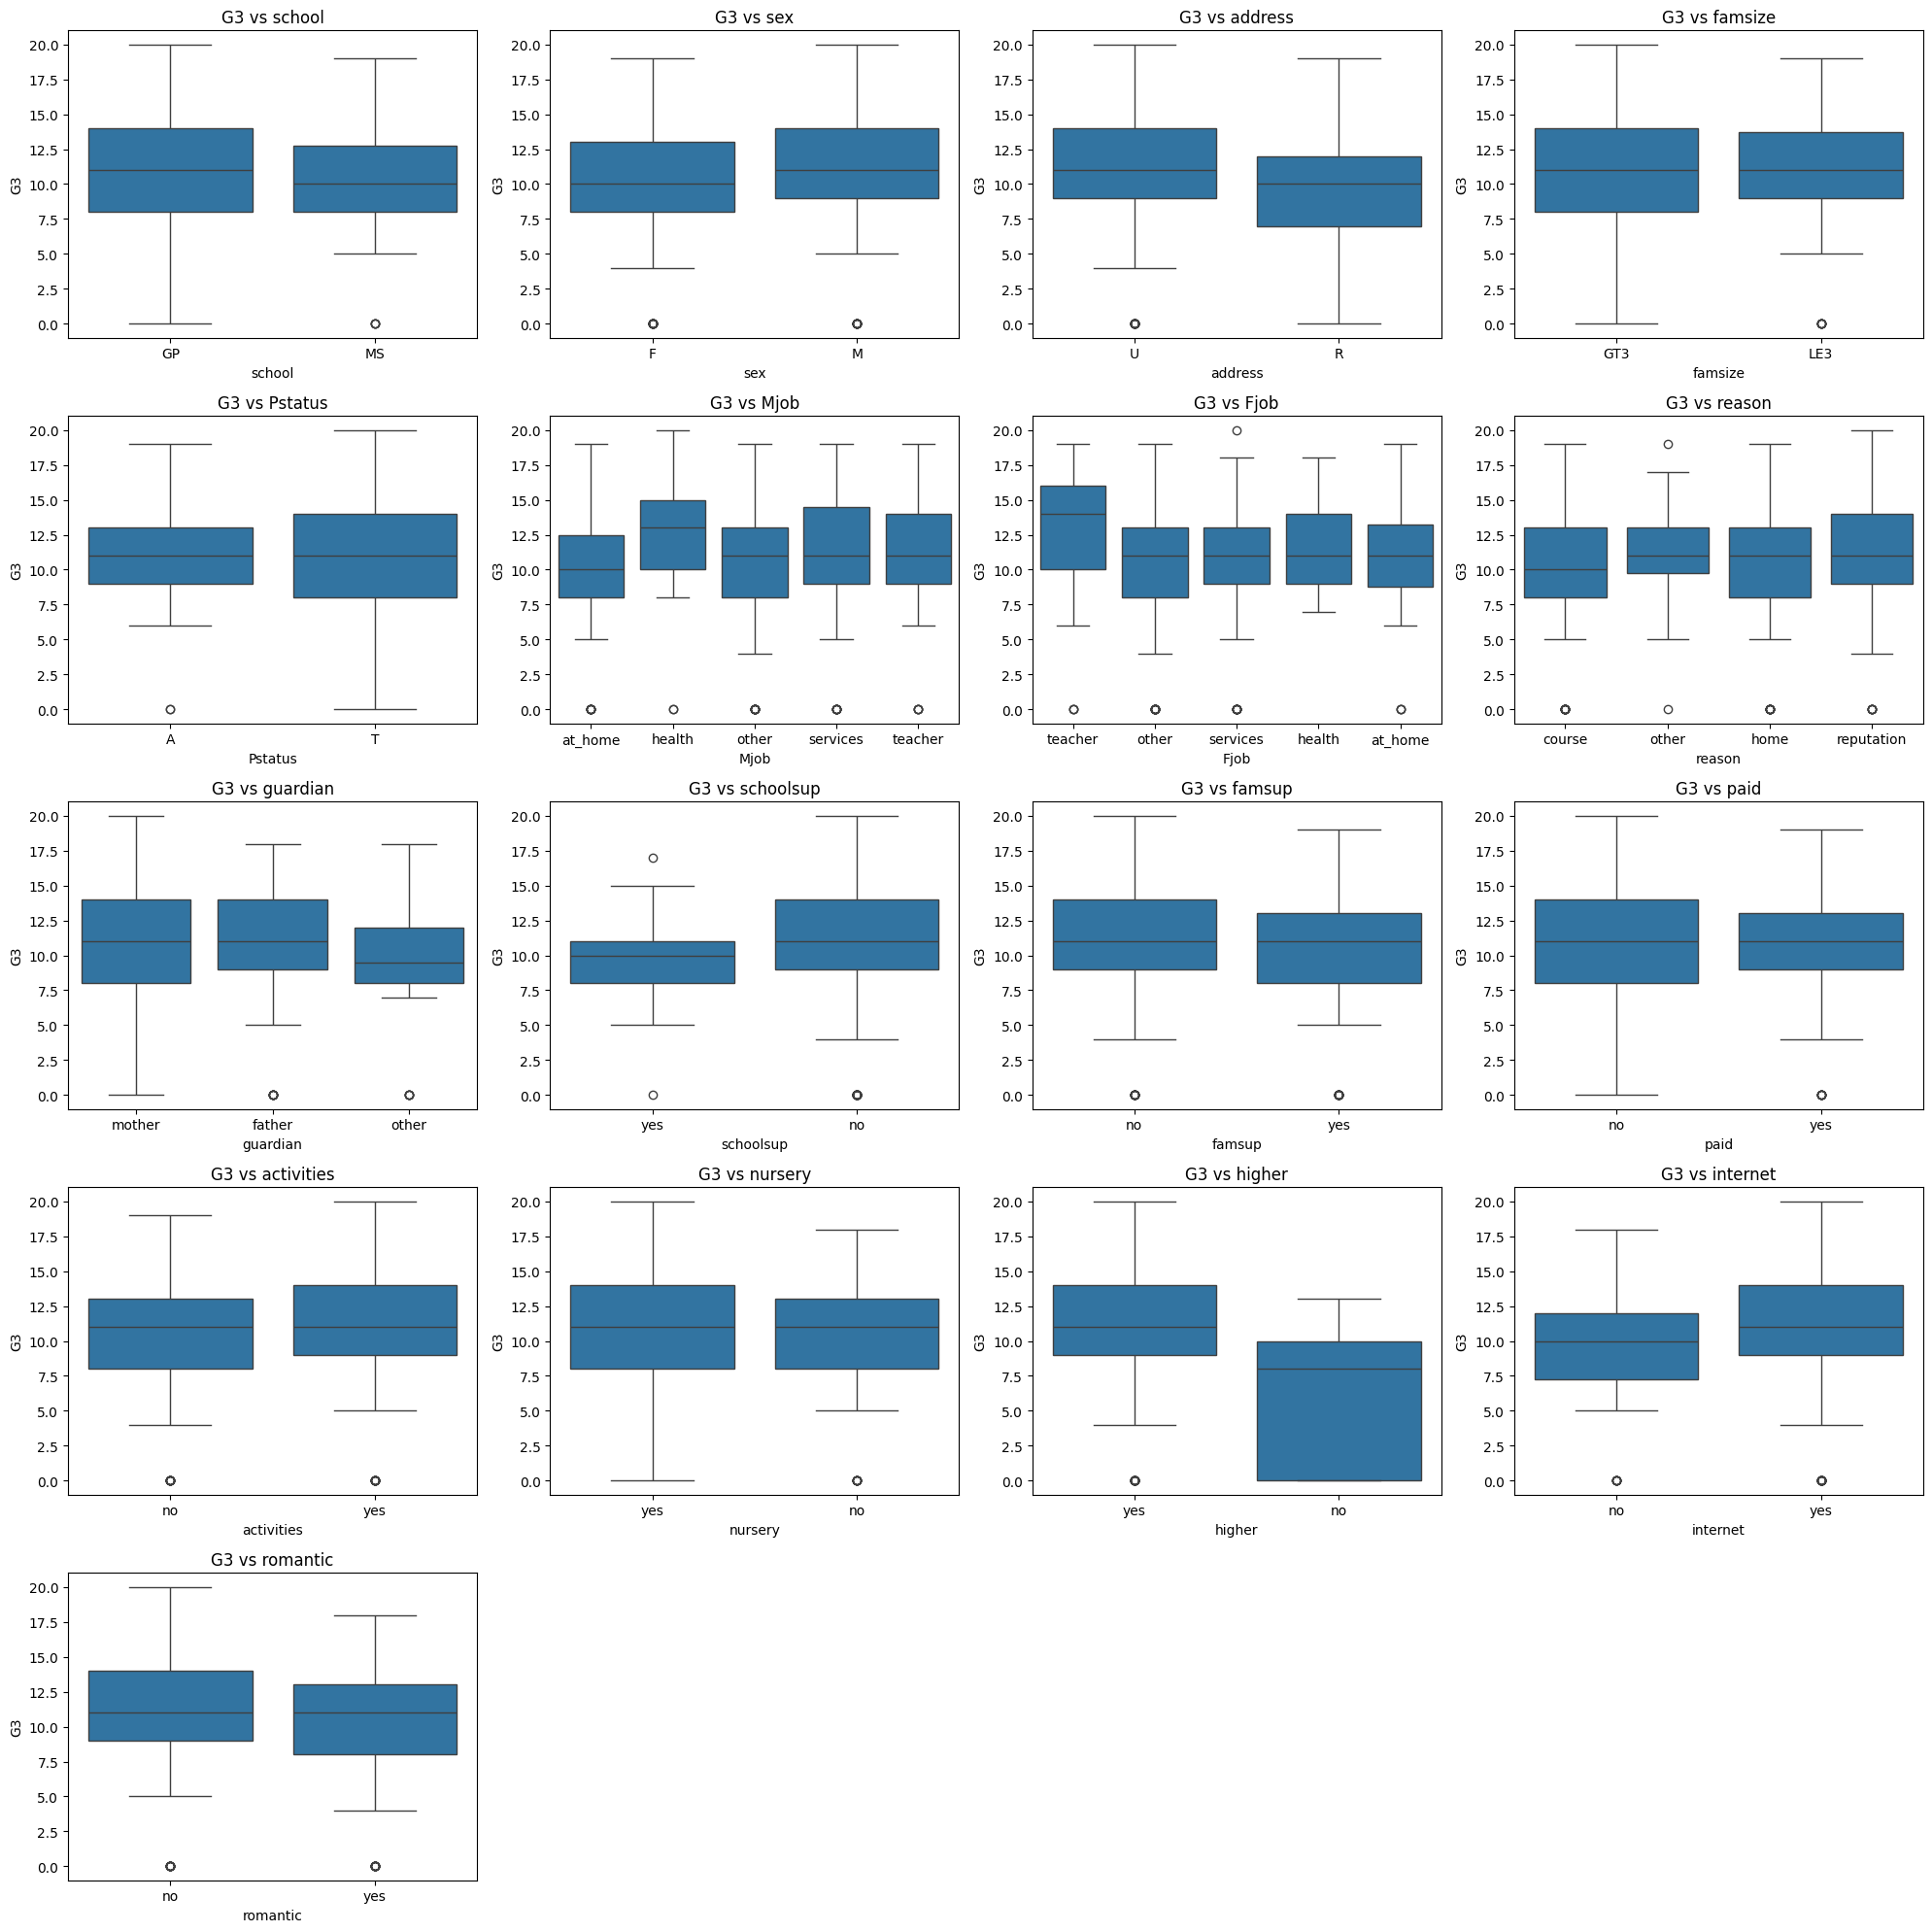

In [11]:
n = len(non_ordinals_features)
nrows = math.ceil(math.sqrt(n))
ncols = math.ceil(n / nrows)

plt.figure(figsize=(5 * ncols, 4 * nrows)) 

for i in range(n):
    plt.subplot(nrows, ncols, i+1)  
    sns.boxplot(x=df[non_ordinals_features[i]], y=df["G3"])
    plt.title(f"G3 vs {non_ordinals_features[i]}")

plt.tight_layout()
plt.show()

Description des résultats :

- Higher (Volonté de faire des études supérieures) : Les élèves qui souhaitent poursuivre des études supérieures (yes) affichent une nette médiane supérieure en $G3$. C'est l'un des impacts les plus forts.
- School (École) : L'école 'GP' montre une note médiane légèrement plus élevée que 'MS'.
- Address (Adresse) : Les élèves vivant en milieu Urbain (U) ont une médiane de $G3$ légèrement supérieure à ceux en milieu Rural (R).
- Pstatus (Statut familial) : Les élèves dont les parents vivent ensemble (T) ont une médiane légèrement plus élevée que ceux vivant séparément (A).
- Sex (Sexe) : Les garçons (M) ont une médiane de $G3$ légèrement plus élevée que les filles (F).
- Romantic (Relation romantique) : Les élèves en relation romantique (yes) semblent avoir une note médiane légèrement inférieure.
- Guardian (Tuteur) : Les élèves dont le tuteur est un parent (mère ou père) ont une médiane plus élevée que les autres tuteurs.
- Famsize, reason, Mjob, Fjob, schoolsup, famsup, paid, activities, nursery, internet : Ces variables montrent des variations minimes ou peu significatives de la médiane de $G3$ entre leurs catégories.

### Conclusion de l'exploration des données

Nous avons pu explorer les features dans leur ensemble :
La note finale $G3$ semble très corrélée aux notes intermédiaires $G1$ et $G2$. Quant aux facteurs d'influence, les variables ordinales montrent que le nombre d'échecs passés (failures) a l'impact négatif le plus significatif sur $G3$. Inversement, la volonté de faire des études supérieures (higher) et l'éducation des parents (Medu, Fedu) sont clairement associées aux meilleures notes. Les autres variables (âge, absences, loisirs, etc.) présentent des corrélations faibles ou très dispersées.

Compte tenu de l'analyse exploratoire, nous avons choisi de conserver l'ensemble des 33 variables disponibles. Toutes les caractéristiques ont, en théorie, le potentiel d'influencer la performance scolaire finale ($G3$).

Avant de passer à l'entraînement des modèles prédictifs, il est essentiel de procéder à la phase de préparation des données. Cette étape inclut la conversion des variables catégorielles en formats numériques exploitables par les algorithmes de Machine Learning.

# 2) Feature Engineering

Nous avons vu que parmi les variables catégorielles, il y a les ordinales et les nominales.

Les variables catégorielles ordonnées (celles avec une échelle, comme le niveau d'éducation) sont déjà sous un format numérique (des chiffres : 1, 2, 3...) que nos modèles de Machine Learning peuvent utiliser directement. L'encodage est fait.

Qu'en est-il des variables catégorielles nominales (celles sans ordre, comme le sexe ou l'adresse) ?

Ces données sont stockées sous format string, et nos modèles ne peuvent pas les comprendre telles quelles. Nous devons les transformer :

1) On pourrait penser à les encoder comme les variables ordonnées. Mais si l'on remplaçait "Urbain" par 1 et "Rural" par 2, le modèle interpréterait qu'il y a une hiérarchie : "Rural" (2) serait considéré comme "plus grand" que "Urbain" (1). Cela reviendrait à introduire une échelle dans des données qui n'en ont pas, ce qui biaiserait l'apprentissage. Ce n'est pas la bonne approche.

2) La bonne solution : L'encodage binaire qu'on appelle One-Hot Encoding (trouvé sur Internet). La méthode correcte consiste à créer une nouvelle colonne binaire (prenant la valeur 0 ou 1) pour chaque catégorie possible. Par exemple, au lieu d'une colonne address avec "Urbain" ou "Rural", nous créerons :

    - address_Urbain (1 si l'élève est urbain, 0 sinon)

    - address_Rural (1 si l'élève est rural, 0 sinon)

De cette manière, nous fournissons au modèle toutes les informations sans lui imposer de relation d'ordre arbitraire. Cette transformation se fait très facilement avec pandas.
On en profite également pour préparer notre dataset pour faire du Machine Learning par la suite dessus.

In [12]:
Y = df["G3"] # Target
X = df.drop("G3", axis=1) # Features

#On va créer les dummies
X_ready = pd.get_dummies(X)

print(f"Dimensions initiales de X: {X.shape}")
print(f"Dimensions après transformation (X_ready): {X_ready.shape}")
print(f"Nouvelles colonnes créées: {X_ready.shape[1] - X.shape[1]}")

Dimensions initiales de X: (395, 32)
Dimensions après transformation (X_ready): (395, 58)
Nouvelles colonnes créées: 26


In [13]:
# On peut vérifier
n = len(non_ordinals_features)
nouvelles_colonnes_créées = 0
for i in range(n):
    nouvelles_colonnes_créées += X[non_ordinals_features[i]].nunique() -1

print(f"Nouvelles colonnes créées (calcul manuel): {nouvelles_colonnes_créées}")

Nouvelles colonnes créées (calcul manuel): 26


In [14]:
X_ready.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,True,False,False,True,False,True,True,False,True,False
1,17,1,1,1,2,0,5,3,3,1,...,True,False,True,False,False,True,False,True,True,False
2,15,1,1,1,2,3,4,3,2,2,...,True,False,False,True,False,True,False,True,True,False
3,15,4,2,1,3,0,3,2,2,1,...,False,True,False,True,False,True,False,True,False,True
4,16,3,3,1,2,0,4,3,2,1,...,True,False,False,True,False,True,True,False,True,False


**Précision importante :** Nous n'avons pas besoin de normaliser nos données pour utiliser le modèle que nous avons choisi jsute après.

# 3) Phase d'apprentissage 

## Modèle 

In [15]:
# Il s'agit maintenant de préparer notre algorithme de machine learning
X_train, X_test, y_train, y_test = train_test_split(X_ready, Y, test_size = 0.2, random_state = 21)

In [16]:
print(X_train.shape)
print(y_train.shape)

(316, 58)
(316,)


Nous avons opté pour le Random Forest Regressor car il est parfaitement adapté à notre objectif, qui est de trouver un modèle à la fois performant et fiable pour prédire les notes.

- **Robustesse, Généralisation (Réduction de la Variance)**

Notre argument principal pour le Random Forest réside est la robustesse.
Ce modèle utilise la méthode de l'agrégation (Bagging) : il construit de nombreux arbres de décision indépendants et combine leurs prédictions.
Cette agrégation réduit le risque de surapprentissage (overfitting). Notre modèle devient ainsi moins sensible aux bruits ou aux spécificités d'un seul élève.

En clair, le Random Forest excelle à la généralisation : il fournit une performance stable et fiable lorsque nous l'appliquons à de nouveaux élèves ou à d'autres jeux de données similaires. Et nous pensons que la généralisation est la priorité.

- **Facilité d'Utilisation**

D'abord il fonctionne très bien sur des jeux de données de taille moyenne. Et surtout il gère naturellement les différents types de variables (numériques, ordinales,...) sans avoir besoin d'une standardisation ou normalisation, ce qui simplifie la phase de préparation des données.

- **Interprétabilité : Importance des Features**

Un avantage crucial pour notre phase exploratoire est que le Random Forest permet de déterminer l'importance des features. Contrairement à d'autres modèles boîtes noires, il nous donne une hiérarchie claire des variables qui ont le plus contribué à la prédiction, ce qui est essentiel pour comprendre les facteurs qui influencent la note finale. 

In [25]:
# Apprentissage du modèle
model = RandomForestRegressor(random_state=21)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Pour comparer, nous testons un modèle XGBoost Regressor.

Les arguments de facilité d'utilisation et d'interprétabilité sont toujours valables pour l'algorithme de XGBoost. L'algorithme XGBoost utilise la notion de Boosting où, similairement à la Random Forest, on combine les décisions de plusieurs arbres. Cependant, la différence réside dans le fait que les arbres de décision ne sont plus indépendants : ils sont construits séquentiellement de sorte que chaque arbre corrige les erreurs du précédent. Plus précisément, XGBoost utilise le Gradient Boosting. Le premier arbre de décision tente de prédire la variable cible, les suivants tentent de prédire l'erreur réalisée par l'arbre précédent (résidus). La décision finale se fait en sommant les décisions de tous les arbres entraînés.

La motivation derrière ce choix est d'essayer de trouver cette fois-ci un algorithme se concentrant sur la réduction du biais. On peut deviner que le XGBoost Regressor sera plus exposé au phénomène de sur-apprentissage. Il est cependant possible de contrôler cela grâce à des techniques de régularisation telle que l'arrêt précoce, le tree-pruning, la pénaliation L1 ou L2 ou encore le sous échantillonnage.

In [26]:
model2 = xgb.XGBRegressor(random_state=21)
model2.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Résultats

In [80]:
y_pred1 = model.predict(X_test)
# Pour une régression d'un modèle de régression supervisé MSE est la métrique classique
mse1 = mean_squared_error(y_test, y_pred1)
print('MSE Random Forest :', np.sqrt(mse1))

y_pred2 = model2.predict(X_test)
# Pour une régression d'un modèle de régression supervisé MSE est la métrique classique
mse2 = mean_squared_error(y_test, y_pred2)
print('MSE XGBoost :', np.sqrt(mse2))

MSE Random Forest : 1.7764371967294679
MSE XGBoost : 1.6462418093582578


RMSE : C'est la racine carrée de l'erreur quadratique moyenne (MSE). Il représente l'écart moyen entre les notes prédites par notre modèle ($Y_{pred}$) et les notes réelles ($Y_{test}$).

Interprétation : Étant donné que les notes ($G3$) vont de $0$ à $20$, un RMSE de $\approx 1.78$ signifie que, en moyenne, la prédiction de notre modèle se trompe d'environ 1,78 point sur l'échelle de $20$.

C'est un bon point de départ. Un écart moyen inférieur à 2 points suggère que le modèle a réussi à capturer une grande partie des relations dans les données. 

Dans le cas du XGBoost Regresor, on trouve une erreur un peu plus faible de $\approx 1.64$.

A ce niveau de l'étude, il est difficile de comparer les deux modèles, puisqu'aucun des deux n'a été réglé (au sens des hyperparamètres), ce qui est l'objet de la partie suivante.


# 4) Hyperparameter Tuning Phase

Maintenant que nous savons que le Random Forest donne des résultats prometteurs (RMSE de 1.7 par exemple), l'objectif est d'améliorer cette performance.

C'est là qu'intervient le tuning des hyperparamètres.

Pour le Random Forest, les hyperparamètres consistent notamment au choix du nombre d'arbres qu'il doit construire (n_estimators), ou de la profondeur maximale de chaque arbre (max_depth) (bien que la profondeur de l'arbre maximale est une des caractéristiques du Random Forest)

Jusqu'à présent, nous avons utilisé les valeurs par défaut du modèle. L'étape suivante consiste à expérimenter différentes combinaisons de ces hyperparamètres. En trouvant la combinaison optimale pour nos données spécifiques, nous pouvons espérer réduire notre RMSE et rendre notre modèle encore plus précis.
Pour réaliser ce Tuning, on utilise la fonction GridSearchCV de Scikit-Learn

In [42]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [20, 30, None]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=21), param_grid, cv=10, scoring='neg_root_mean_squared_error', verbose=3)
grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score : {grid_search.best_score_}")

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10] END ..max_depth=20, n_estimators=100;, score=-1.229 total time=   0.2s
[CV 2/10] END ..max_depth=20, n_estimators=100;, score=-1.626 total time=   0.2s
[CV 3/10] END ..max_depth=20, n_estimators=100;, score=-0.854 total time=   0.8s
[CV 4/10] END ..max_depth=20, n_estimators=100;, score=-1.720 total time=   0.3s
[CV 5/10] END ..max_depth=20, n_estimators=100;, score=-2.247 total time=   0.2s
[CV 6/10] END ..max_depth=20, n_estimators=100;, score=-2.583 total time=   0.2s
[CV 7/10] END ..max_depth=20, n_estimators=100;, score=-0.794 total time=   0.3s
[CV 8/10] END ..max_depth=20, n_estimators=100;, score=-1.862 total time=   0.2s
[CV 9/10] END ..max_depth=20, n_estimators=100;, score=-1.366 total time=   0.2s
[CV 10/10] END .max_depth=20, n_estimators=100;, score=-1.469 total time=   0.2s
[CV 1/10] END ..max_depth=20, n_estimators=200;, score=-1.257 total time=   0.4s
[CV 2/10] END ..max_depth=20, n_estimators=200;,

In [46]:
param ={
    "n_estimators": 100,
    'max_depth': 20,
    "random_state": 21
}

model1_final = RandomForestRegressor(**param)
model1_final.fit(X_train, y_train)

y_pred1 = model1_final.predict(X_test)
# Pour une régression d'un modèle de régression supervisé MSE est la métrique classique
mse1 = mean_squared_error(y_test, y_pred1)
print('MSE finale Random Forest :', np.sqrt(mse1))

MSE finale Random Forest : 1.7764371967294679


Puisqu'on utilise le `scoring neg_root_mean_squared_error`, le score est négatif. Le RMSE (Root Mean Squared Error) optimal est donc de 1.55 points.
Le modèle optimal utilise la profondeur maximale illimitée (``max_depth= None``) et le nombre d'arbres par défaut (``n_estimators= 100``). Ces paramètres indiquent que le Random Forest nécessite des arbres pleinement déployés (profonds) et le nombre d'arbres par défaut pour atteindre sa performance maximale.

Notre erreur minimale est de $1.55$ points, et cela avec la meilleure combianison de paramètre pour notre modèle. Donc si nous voulons contnuer à réduire l'erreur nous devons changer de modèle
Pour rappel, nous utilisions Random Fores: il est conçu pour réduire la variance (il évite le surapprentissage) en agrégeant plusieurs arbres. En contrepartie, son biais est souvent plus élevé que d'autres modèles avancés, et notamment les modèles de Boosting (comme XGBoost) : Ce type de modèle, construit séquentiellement pour corriger les erreurs des modèles précédents, est spécifiquement conçu pour réduire le biais.

Si nous voulions réduire l'erreur (donc le biais) sous les $1.55$ points, le Boosting (par exemple, XGBoost) serait le candidat naturel.

Cependant, le choix d'un modèle plus puissant comme le Boosting vient avec une mise en garde. Parce que c'est connu que le Boosting est plus sensible à l'overfitting : il est tellement efficace pour réduire le biais qu'il risque de trop bien apprendre les bruits et les spécificités du jeu d'entraînement, ce qui dégraderait l'erreur de généralisation sur des données nouvelles.

Ce choix nous ramène directement au compromis Biais-Variance :
- Random Forest : Faible Variance (Robuste) / Biais Modéré.
- Boosting : Faible Biais (Très précis) / Risque accru de Variance (Moins robuste sans un tuning parfait).

Pour valider réellement la performance de $1.55$, l'étape essentielle consiste à calculer l'erreur de généralisation en évaluant ce modèle optimal sur le jeu de test final (``X_test``), que le modèle n'a jamais vu. Et en fait ce modèle on l'a déjà, c'est le modèle par défaut que nous avions calculé. L'erreur de généralisation était de 1.78. Elle n'est pas tellement plus élevé que l'erreur sur les odnnées d'entraînement, ce qui signifie que nous n'avons pas d'overfitting significatif. Donc elle est essentiellement due au biais.

Réalisons l'étape de réglage des hyperparamètres pour le XGBoost Regressor. On utilise aussi une approche exhaustive GridSearchCV. Il y a différents type d'hyperparamètres que l'on peut régler.

- Les paramètres qui contrôlent la stratégie de gradient boosting: `n_estimators`, `learning_rate`.
- Les paramètres spécifiques à la structure de chaque arbre: `max_depth`, `min_child_depth`.
- Les paramètres de pénalisation pour la régularisation: `lambda` (L2), et `alpha` (L1).
- (Non testés) Les paramètres introduisant de l'aléatoire : `subsample`, `colsample_bytree`
- et bien plus...

Par souci de temps de calcul, nous avons fixé la stratégie de gradient boosting avec un `learning_rate` et un `n_estimators` fixes. Nous nous sommes concentrés sur le réglage des hyperparamètres liés à la structure des arbres et à la régularisation.

In [92]:
param ={
    "learning_rate": 0.01,
    "n_estimators": 500,
    "random_state": 21
}

param_grid = {
    # 1. Tree Structure (Complexity Control)
    'max_depth': [5, 7],
    'min_child_weight': [5, 10],

    # 2. Boosting Parameters (Speed/Accuracy Trade-off)
    # 'learning_rate': [0.01, 0.1, 0.3], # Also known as 'eta'

    # 3. Regularization (Prevent Overfitting)
    # 'gamma': [0.0, 0.1, 0.5], # Minimum loss reduction required to make a further partition
    'lambda': [1, 10],      # L2 regularization term on weights (like 'reg_lambda')
    'alpha': [0, 1.0],        # L1 regularization term on weights (like 'reg_alpha')

    # # 4. Sampling (Introduce Randomness)
    # 'subsample': [0.7, 0.9],         # Fraction of samples to be randomly sampled for building trees
    # 'colsample_bytree': [0.7, 0.9],  # Fraction of columns (features) to be randomly sampled for each tree
}

grid_search = GridSearchCV(xgb.XGBRegressor(**param), param_grid=param_grid, cv=10, scoring='neg_root_mean_squared_error', verbose=3)
grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score : {grid_search.best_score_}")

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10] END alpha=0, lambda=1, max_depth=5, min_child_weight=5;, score=-1.511 total time=   0.7s
[CV 2/10] END alpha=0, lambda=1, max_depth=5, min_child_weight=5;, score=-1.861 total time=   0.2s
[CV 3/10] END alpha=0, lambda=1, max_depth=5, min_child_weight=5;, score=-0.930 total time=   0.2s
[CV 4/10] END alpha=0, lambda=1, max_depth=5, min_child_weight=5;, score=-1.983 total time=   0.3s
[CV 5/10] END alpha=0, lambda=1, max_depth=5, min_child_weight=5;, score=-2.588 total time=   0.2s
[CV 6/10] END alpha=0, lambda=1, max_depth=5, min_child_weight=5;, score=-3.056 total time=   0.2s
[CV 7/10] END alpha=0, lambda=1, max_depth=5, min_child_weight=5;, score=-0.798 total time=   0.3s
[CV 8/10] END alpha=0, lambda=1, max_depth=5, min_child_weight=5;, score=-1.636 total time=   0.2s
[CV 9/10] END alpha=0, lambda=1, max_depth=5, min_child_weight=5;, score=-1.470 total time=   0.2s
[CV 10/10] END alpha=0, lambda=1, max_depth=5,

In [112]:
param ={
    "learning_rate": 0.01,
    "n_estimators": 500,
    'alpha': 0,
    'lambda': 10,
    'max_depth': 5,
    'min_child_weight': 10,
    "random_state": 21
}

# Meilleure combinaison trouvée au hasard manuellement, donne un score de 1.60
# param ={
#     "learning_rate": 0.01,
#     "n_estimators": 500,
#     'alpha': 0,
#     'lambda': 1,
#     'max_depth': 7,
#     'min_child_weight': 10,
#     "random_state": 21
# }

model2_final = xgb.XGBRegressor(**param)
model2_final.fit(X_train, y_train)

y_pred2 = model2_final.predict(X_test)
# Pour une régression d'un modèle de régression supervisé MSE est la métrique classique
mse2 = mean_squared_error(y_test, y_pred2)
print('MSE finale XGBoost :', np.sqrt(mse2))

MSE finale XGBoost : 1.7198759379112292


On observe une erreur de 1.58 points sur le training set et de 1.72 sur le testing set. La prédiction est légèrement meilleure que pour le Random Forest.

Après GridSearch, on a trouvé une combinaison d'hyperparamètres avec une erreur de généralisation plus grande que la combinaison par défaut (1.65). Cela montre les limites de la technique de GridSearch, qui certes effectue une recherche exhaustive mais qui est totalement dépendante du choix initial de l'espace de recherche (choix de la grid). Et plus les modèles et datasets sont complexes, plus il est difficile de déterminer une grille qui contient la combinaison d'hyperparamètres optimale. 

On a donc au vu de nos résultats UN modèle de XGBoost qui est meilleur qu'UN autre modèle de Random Forest, mais une étude différente aurait pu trouver le contraire. 

Une stratégie d'amélioration serait d'effectuer une recherche d'hyperparamètres d'abord plus globale différences d'échelles entre les différentes valeurs (par Grid Search ou Random Search). Puis après avoir trouvé les régions potentiellement optimales, réeffectuer une recherche locale et plus fine. L'optimisation bayésienne est aussi une autre piste à explorer.

# 5) Conclusion

Le Random Forest ne fait pas que prédire ; il nous offre aussi une interprétation de ses résultats en nous indiquant quelles variables ont été les plus utiles pour faire la prédiction. Nous allons maintenant examiner l'importance des features pour comprendre d'où vient notre performance.

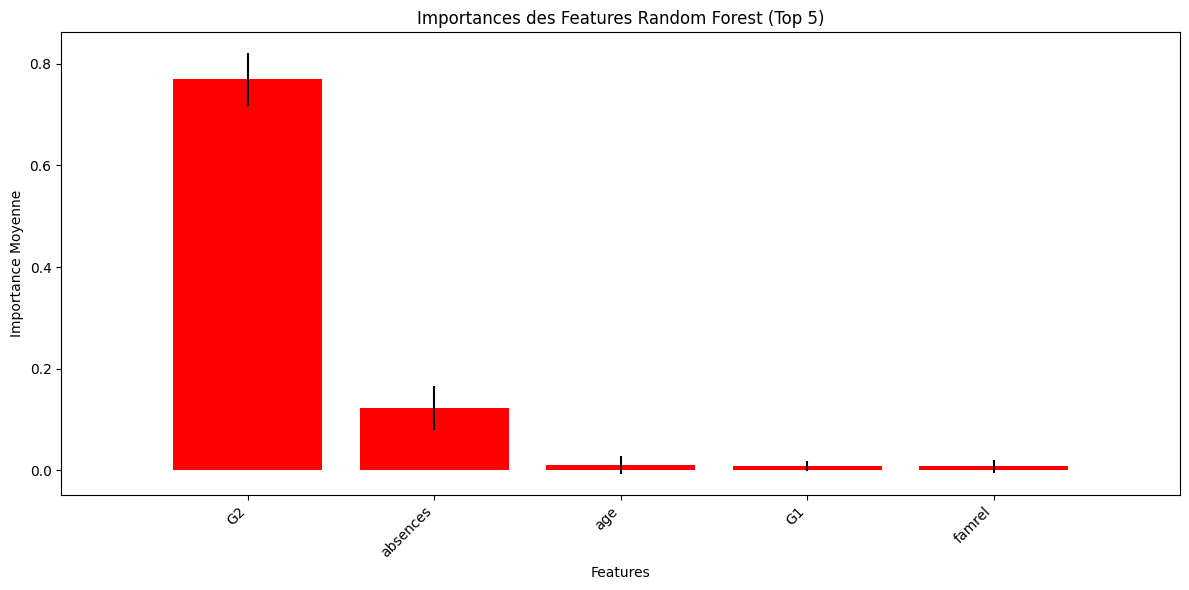

In [99]:
importances = model1_final.feature_importances_
std = np.std([tree.feature_importances_ for tree in model1_final.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
sorted_feature_names = X_train.columns[indices]
N_TOP_FEATURES = 5
top_indices = indices[:N_TOP_FEATURES]
top_names = sorted_feature_names[:N_TOP_FEATURES]

plt.figure(figsize=(12, 6))
plt.title(f"Importances des Features Random Forest (Top {N_TOP_FEATURES})")
plt.bar(
    range(N_TOP_FEATURES), 
    importances[top_indices], 
    color="r", 
    yerr=std[top_indices], 
    align="center"
)
plt.xticks(
    range(N_TOP_FEATURES), 
    top_names, 
    rotation=45,
    ha="right"
)
plt.xlim([-1, N_TOP_FEATURES])
plt.ylabel("Importance Moyenne")
plt.xlabel("Features")
plt.tight_layout() 
plt.show() 


Le graphique ci-dessus montre clairement quelles sont les principales variables qui influencent le plus la note finale en mathématiques ($G3$) :

- $G2$ (Note du Semestre Précédent) : Cette variable est massivement dominante, avec une importance moyenne supérieure à $0.75$. Elle explique, à elle seule, la grande majorité de la performance du modèle. Il est logique que la performance immédiate d'un élève soit le meilleur indicateur de sa performance future.
- $absences$ : C'est la deuxième variable la plus importante, mais son influence est bien plus faible (autour de $0.13$). Cela suggère que la régularité est un facteur secondaire, mais non négligeable.
- Les autres variables : L'âge ($age$), la première note du semestre ($G1$) et les relations familiales ($famrel$) ont une importance quasi nulle dans ce modèle.

En résumé, la prédiction de la note finale ($G3$) en mathématiques est presque entièrement basée sur la note du semestre précédent ($G2$).

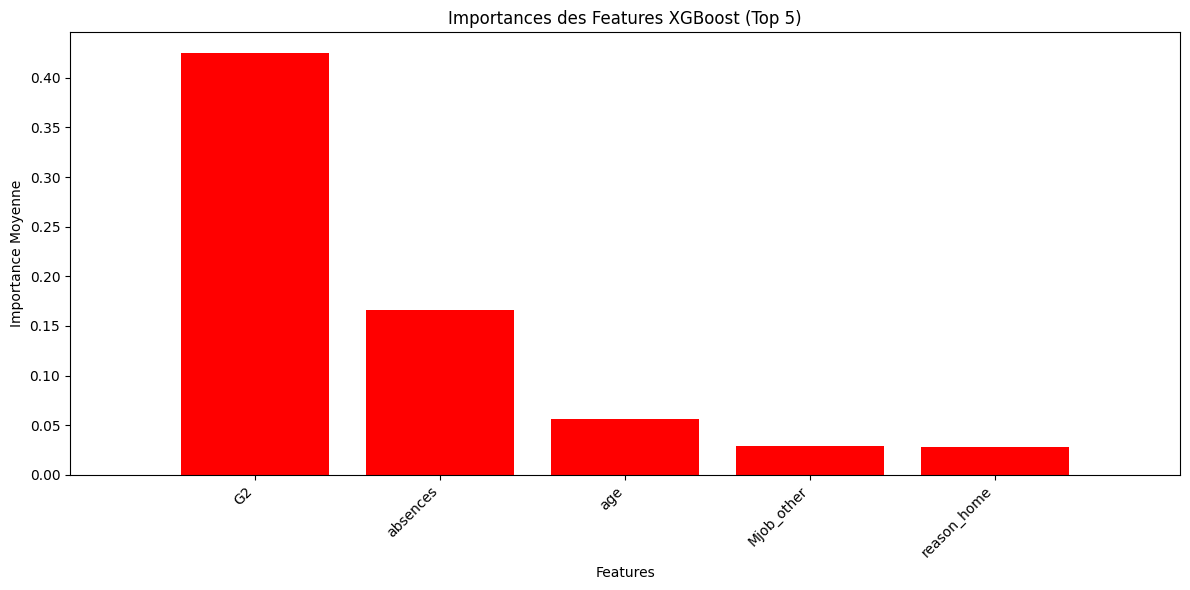

In [100]:
importances = model2_final.feature_importances_

indices = np.argsort(importances)[::-1]
sorted_feature_names = X_train.columns[indices]
N_TOP_FEATURES = 5
top_indices = indices[:N_TOP_FEATURES]
top_names = sorted_feature_names[:N_TOP_FEATURES]

plt.figure(figsize=(12, 6))
plt.title(f"Importances des Features XGBoost (Top {N_TOP_FEATURES})")
plt.bar(
    range(N_TOP_FEATURES), 
    importances[top_indices], 
    color="r", 
    align="center"
)
plt.xticks(
    range(N_TOP_FEATURES), 
    top_names, 
    rotation=45,
    ha="right"
)
plt.xlim([-1, N_TOP_FEATURES])
plt.ylabel("Importance Moyenne")
plt.xlabel("Features")
plt.tight_layout() 
plt.show() 


Le modèle de XGBoost trouve des importances relatives de features similaires avec dans l'ordre `G2`, `absences`, et `age` étant les variables influençant le plus les décisions des arbres

## Ouverture

Nous voyons donc que notre capacité à prédire la note finale ($G3$) avec une erreur de $1.73$ points repose presque entièrement sur les notes obtenues au semestre précédent ($G2$). Notre modèle confirme une forte corrélation entre la performance immédiate passée et la performance finale.
Les questions qui se posent sont les suivantes :

- Est-il possible de prédire les notes du Semestre 2 avec la même précision, en utilisant les notes du Semestre 1 ($G1$ et $G2$) comme principales features ? La logique et ce graphique suggèrent que oui.

- Le challenge le plus intéressant serait de déterminer comment prédire la performance des élèves AVANT qu'ils n'aient des notes de semestre (G1, G2). C'est-à-dire, comment prédire la note de $G1$ ou $G2$ uniquement avec des variables sociales,démographiques, comportementales, et familiales. C'est dans ce scénario que les autres features comme l'âge, les absences et l'environnement social prendraient toute leur importance.

# Pour aller plus loin

## Notre première idée

On peut désormais s'attaquer aux idées qu'on a évoqué.
Avec le même modèle on va essayer de prédire $G2$ en fonction des autres features (et on enlève $G3$).
Les étapes sont les mêmes que pour la partie précédente.


In [101]:
Y_2 = df["G2"] # Target
X_2 = df.drop(["G3", "G2"], axis=1) # Features

#On va créer les dummies
X_2ready = pd.get_dummies(X_2)

print(f"Dimensions initiales de X_2: {X_2.shape}")
print(f"Dimensions après transformation (X_2ready): {X_2ready.shape}")
print(f"Nouvelles colonnes créées: {X_2ready.shape[1] - X_2.shape[1]}")

Dimensions initiales de X_2: (395, 31)
Dimensions après transformation (X_2ready): (395, 57)
Nouvelles colonnes créées: 26


In [102]:
# Il s'agit maintenant de préparer notre algorithme de machine learning
X_2train, X_2test, y_2train, y_2test = train_test_split(X_2ready, Y_2, test_size = 0.2, random_state = 21)

In [103]:
# Apprentissage du modèle
model2 = RandomForestRegressor(random_state=21)
model2.fit(X_2train, y_2train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [104]:
y_2pred = model2.predict(X_2test)
# Pour une régression d'un modèle de régression supervisé MSE est la métrique classique
mse2 = mean_squared_error(y_2test, y_2pred)
print(np.sqrt(mse2))

2.656043026188022


L'erreur de $2.66$ est significativement plus élevée que l'erreur de $1.71$ qu'on avait probablement obtenu lors de la prédiction de $G3$ (en utilisant $G2$). Prédire $G2$ est plus difficile que prédire $G3$, pourtant on a à disposition la note précédente $G1$, comme on avait $G2$, pour pédire $G3$. En fait ce qu'il manque c'est encore une note précédente pour affiner le prédiction. Pour prédire $G3$, on avait $G2$ et $G1$, mais pour prédire $G2$, on a plus que $G1$.

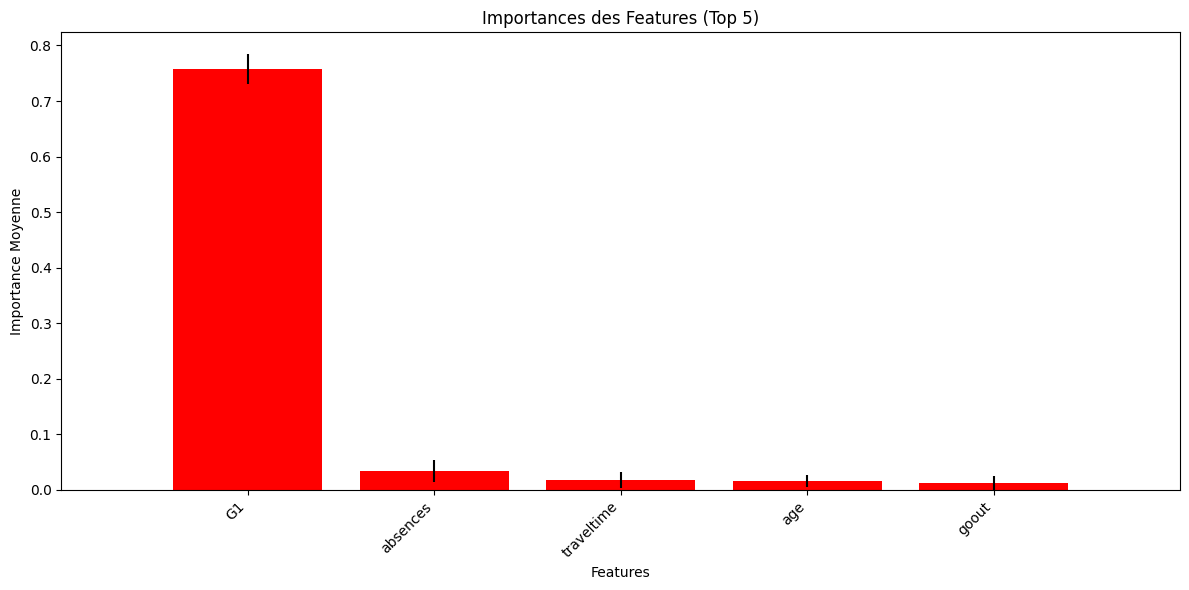

In [105]:
importances2 = model2.feature_importances_
std2 = np.std([tree.feature_importances_ for tree in model2.estimators_], axis=0)
indices2 = np.argsort(importances2)[::-1]
sorted_feature_names2 = X_2train.columns[indices2]
N_TOP_FEATURES = 5
top_indices2 = indices2[:N_TOP_FEATURES]
top_names2 = sorted_feature_names2[:N_TOP_FEATURES]

plt.figure(figsize=(12, 6))
plt.title(f"Importances des Features (Top {N_TOP_FEATURES})")
plt.bar(
    range(N_TOP_FEATURES), 
    importances2[top_indices2], 
    color="r", 
    yerr=std2[top_indices2], 
    align="center"
)
plt.xticks(
    range(N_TOP_FEATURES), 
    top_names2, 
    rotation=45,
    ha="right"
)
plt.xlim([-1, N_TOP_FEATURES])
plt.ylabel("Importance Moyenne")
plt.xlabel("Features")
plt.tight_layout() 
plt.show() 


La variable $G1$ (note du premier trimestre) absorbe presque toute la capacité prédictive, avec une importance moyenne autour de $0.77$.
L'impact de toutes les autres variables socio-démographiques, comportementales et familiales est extrêmement faible (proche de zéro) en comparaison. Même les meilleures (absences, traveltime) ne contribuent qu'à quelques pourcents de l'importance totale.
Ce scénario démontre que la note du premier trimestre ($G1$) est le seul facteur vraiment déterminant pour prédire la note du deuxième trimestre ($G2$). Les facteurs sociaux et comportementaux n'ajoutent qu'une valeur prédictive négligeable.

Nos résultats valident votre hypothèse initiale :La prédiction de $G3$ reposait sur $G2$.
La prédiction de $G2$ repose désormais sur $G1$.
On est donc confronté au véritable défi qu'on a identifié : la seule manière de donner de l'importance aux facteurs socio-démographiques (absences, age, studytime, failures, etc.) est de passer à la prédiction de $G1$ où aucune note antérieure n'est disponible.

## Notre deuxième idée

In [106]:
Y_3 = df["G1"] # Target
X_3 = df.drop(["G3", "G2", "G1"], axis=1) # Features

#On va créer les dummies
X_3ready = pd.get_dummies(X_3)

print(f"Dimensions initiales de X_3: {X_3.shape}")
print(f"Dimensions après transformation (X_3ready): {X_3ready.shape}")
print(f"Nouvelles colonnes créées: {X_3ready.shape[1] - X_3.shape[1]}")

Dimensions initiales de X_3: (395, 30)
Dimensions après transformation (X_3ready): (395, 56)
Nouvelles colonnes créées: 26


In [107]:
# Il s'agit maintenant de préparer notre algorithme de machine learning
X_3train, X_3test, y_3train, y_3test = train_test_split(X_3ready, Y_3, test_size = 0.2, random_state = 21)

In [108]:
# Apprentissage du modèle
model3 = RandomForestRegressor(random_state=21)
model3.fit(X_3train, y_3train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [109]:
y_3pred = model3.predict(X_3test)
# Pour une régression d'un modèle de régression supervisé MSE est la métrique classique
mse3 = mean_squared_error(y_3test, y_3pred)
print(np.sqrt(mse3))

3.336878136252886


L'erreur de $3.34$ est la plus élevée de nos trois scénarios. Cela confirme que plus on s'éloigne des notes antérieures, plus la prédiction devient difficile. Un RMSE de $3.34$ indique que les facteurs de fond seuls ont un pouvoir prédictif modéré pour expliquer la première performance de l'élève.

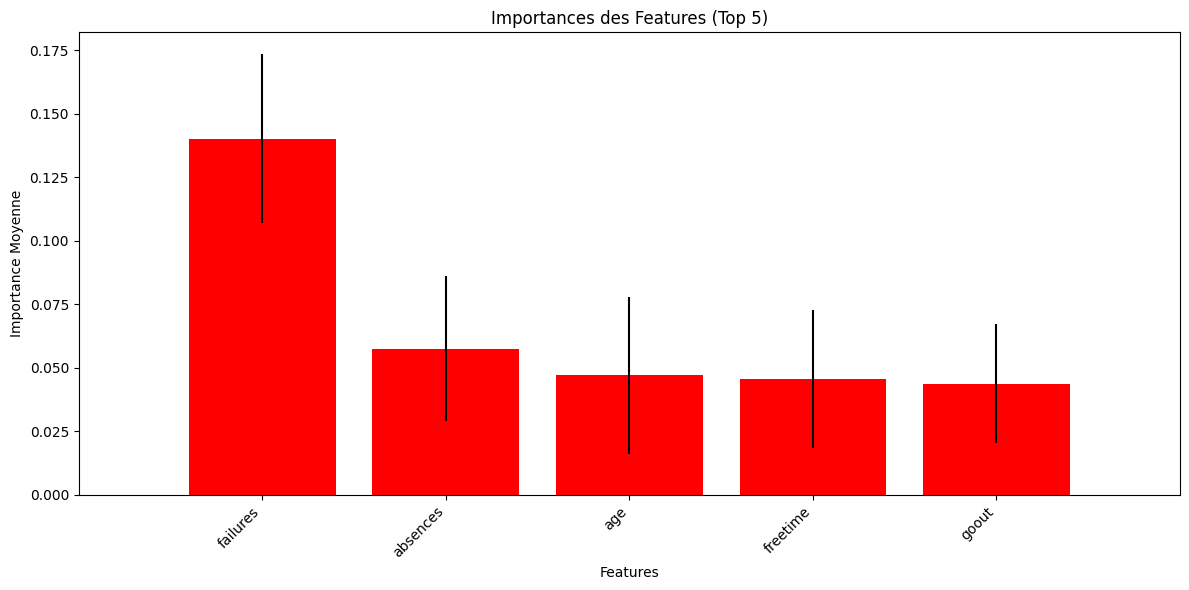

In [110]:
importances3 = model3.feature_importances_
std3 = np.std([tree.feature_importances_ for tree in model3.estimators_], axis=0)
indices3 = np.argsort(importances3)[::-1]
sorted_feature_names3 = X_3train.columns[indices3]
N_TOP_FEATURES = 5
top_indices3 = indices3[:N_TOP_FEATURES]
top_names3 = sorted_feature_names3[:N_TOP_FEATURES]

plt.figure(figsize=(12, 6))
plt.title(f"Importances des Features (Top {N_TOP_FEATURES})")
plt.bar(
    range(N_TOP_FEATURES), 
    importances3[top_indices3], 
    color="r", 
    yerr=std3[top_indices3], 
    align="center"
)
plt.xticks(
    range(N_TOP_FEATURES), 
    top_names3, 
    rotation=45,
    ha="right"
)
plt.xlim([-1, N_TOP_FEATURES])
plt.ylabel("Importance Moyenne")
plt.xlabel("Features")
plt.tight_layout() 
plt.show() 


Le graphique des importances est désormais le plus révélateur, car il montre enfin le poids des facteurs non académiques :
1. Failures (Échecs passés) : C'est de loin le facteur le plus important, avec une contribution d'environ $0.14$. Cela suggère que l'historique d'échecs d'un élève, même dans d'autres cours, est le meilleur prédicteur de sa note initiale en Mathématiques ($G1$).
2. Absences : Le nombre d'absences est le deuxième facteur le plus pertinent, soulignant que l'assiduité est un indicateur précoce de performance.
3. Age, Freetime, Goout : Ces variables (âge, temps libre, sorties entre amis) occupent le reste du Top 5. Leur importance est significativement plus élevée que dans le scénario précédent (où $G1$ dominait), mais elles restent relativement proches les unes des autres.

Dans ce scénario de "prédiction de fond", le modèle ne peut plus s'appuyer sur des notes antérieures. L'importance se répartit enfin sur les variables comportementales et historiques. Ce résultat permet de répondre à notre question initiale : le nombre d'échecs passés (failures) est le facteur de risque principal pour la performance de l'élève au premier trimestre.